In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import uproot3
import R2h_module_2d as r2h
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import seaborn as sns
import cupy as cp, math, pylab
import os, os.path
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 13}) 
mpl.rcParams.update({'ytick.labelsize': 13}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'


plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Welcome to JupyROOT 6.27/01


/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


**Definition of some constants**

In [2]:
#change this to where you want to save the output plots

plots_dir='/home/sebouh/Documents/Overleaf_git/Dihadron2D_AN/figures/results/main/'
tables_dir='/home/sebouh/Documents/Overleaf_git/Dihadron2D_AN/tables'


# Get data from Ntuples to dataframes

In [3]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

# Getting Data

In [4]:
%%time
df = {}
df_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.07 s, sys: 390 ms, total: 4.47 s
Wall time: 4.81 s


In [5]:
print(df['C'].columns)

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt'],
      dtype='object')


In [6]:
#df['C'].hist(figsize=(12,12),bins=100,column=['nu','t','Q2','h2_pid', 'h1_pid','h1_xf', 'h2_xf'])
#plt.show()

# Getting GiBUU

In [7]:
%%time

pathGIBUU="/home/miguel/eg2dihadron/"
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), 
                                                           '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), target)
print (df_trigger.keys())

D
 trigger
 pairs
C
 trigger
 pairs
Fe
 trigger
 pairs
Pb
 trigger
 pairs
dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'GiBUU_D_trigger', 'GiBUU_C_trigger', 'GiBUU_Fe_trigger', 'GiBUU_Pb_trigger'])
CPU times: user 14.6 s, sys: 1.04 s, total: 15.6 s
Wall time: 17.2 s


# Apply selection to datasets
**Here are applied the cuts for GiBUU**

In [85]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC, nomCuts=True)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC, nomCuts=True)


key:  C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 29244  (100.00  %)
2.2 < nu < 4.2 29244  (100.00  %)
10<h2_th 29244  (100.00  %)
10< h1_th 29244  (100.00  %)

key:  D_C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 47014  (100.00  %)
2.2 < nu < 4.2 47014  (100.00  %)
10<h2_th 47014  (100.00  %)
10< h1_th 47014  (100.00  %)

key:  Fe
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 31958  (100.00  %)
2.2 < nu < 4.2 31958  (100.00  %)
10<h2_th 31958  (100.00  %)
10< h1_th 31958  (100.00  %)

key:  D_Fe
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 75140  (100.00  %)
2.2 < nu < 4.2 75140  (100.00  %)
10<h2_th 75140  (100.00  %)
10< h1_th 75140  (100.00  %)

key:  Pb
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 10125  (100.00  %)
2.2 < nu < 4.2 10125  (100.00  %)
10<h2_th 10125  (100.00  %)
10< h1_th 10125  (100.00  %)

key:  D_Pb
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 71

In [86]:
for key in df_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    
    

C_trigger False
 
D_C_trigger False
 
Fe_trigger False
 
D_Fe_trigger False
 
Pb_trigger False
 
D_Pb_trigger False
 
GiBUU_D_trigger True
 
GiBUU_C_trigger True
 
GiBUU_Fe_trigger True
 
GiBUU_Pb_trigger True
 


In [87]:

df_mc = {}
df_mc_trigger = {}
path_mc="/home/seba/CreatePairTuples"
#path_mc="/home/sebouh/di-hadron/simul/Pairs"
for target in ['C','D', 'Fe','Pb']:
#for target in ['C','D']:
    print ('Getting dataframes from target %s'%target)
    df_mc[target]=getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), target)
    df_mc_trigger['%s_trigger'%target] = getdatainChunks('%s/MC_Pairs_%s.root'%(path_mc,target), 
                                                         '%s_trigger'%target)
for key in df_mc.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print (key)
    print('trigger cuts:\n')
    df_mc[key] = r2h.applyCuts(df_mc[key],isMC=isMC)
    print('pair cuts:\n')
    df_mc[key] = r2h.applyCutsPair(df_mc[key],isMC=isMC)    
    #df_mc[key] = r2h.applyCuts(df_mc[key],isMC=isMC)
    #df_mc[key] = r2h.applyCutsPair(df_mc[key],isMC=isMC)

Getting dataframes from target C
Getting dataframes from target D
Getting dataframes from target Fe
Getting dataframes from target Pb
C
trigger cuts:

pair cuts:

Starting election on dipion variables
This is Data
1.0< Q2 <4.0 661810  (100.00  %)
2.2 < nu < 4.2 661810  (100.00  %)
10<h2_th 245486  (100.00  %)
10< h1_th 233698  (100.00  %)
D
trigger cuts:

pair cuts:

Starting election on dipion variables
This is Data
1.0< Q2 <4.0 669397  (100.00  %)
2.2 < nu < 4.2 669397  (100.00  %)
10<h2_th 246638  (100.00  %)
10< h1_th 234565  (100.00  %)
Fe
trigger cuts:

pair cuts:

Starting election on dipion variables
This is Data
1.0< Q2 <4.0 613645  (100.00  %)
2.2 < nu < 4.2 613645  (100.00  %)
10<h2_th 227694  (100.00  %)
10< h1_th 216812  (100.00  %)
Pb
trigger cuts:

pair cuts:

Starting election on dipion variables
This is Data
1.0< Q2 <4.0 646359  (100.00  %)
2.2 < nu < 4.2 646359  (100.00  %)
10<h2_th 239630  (100.00  %)
10< h1_th 228077  (100.00  %)


In [88]:
df['GiBUU_C'].columns

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')

In [89]:
#define the cuts used for the data.  These should be cleaned up for clarity
p_thr=2.7
Nphe_thr=5
minz2=0.05
maxz2=0.95
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)



pair_cut_nom  ='and h1_th>10 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and (h1_p+h2_p)<nu and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

In [90]:
#set up some things regarding plotting style
import imp
imp.reload(mpl)
import mplhep as hep
hep.set_style("CMS")

symbols={"C":"o","Fe":"s", "Pb": "v"}
linestyles={"C":"-", "Fe":"--","Pb":"-."}

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCutPiPlus', 'h2_FidCutPiPlus',
       'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt',
       'inelasticity', 'h1_e', 'h1_p', 'z_tot', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')


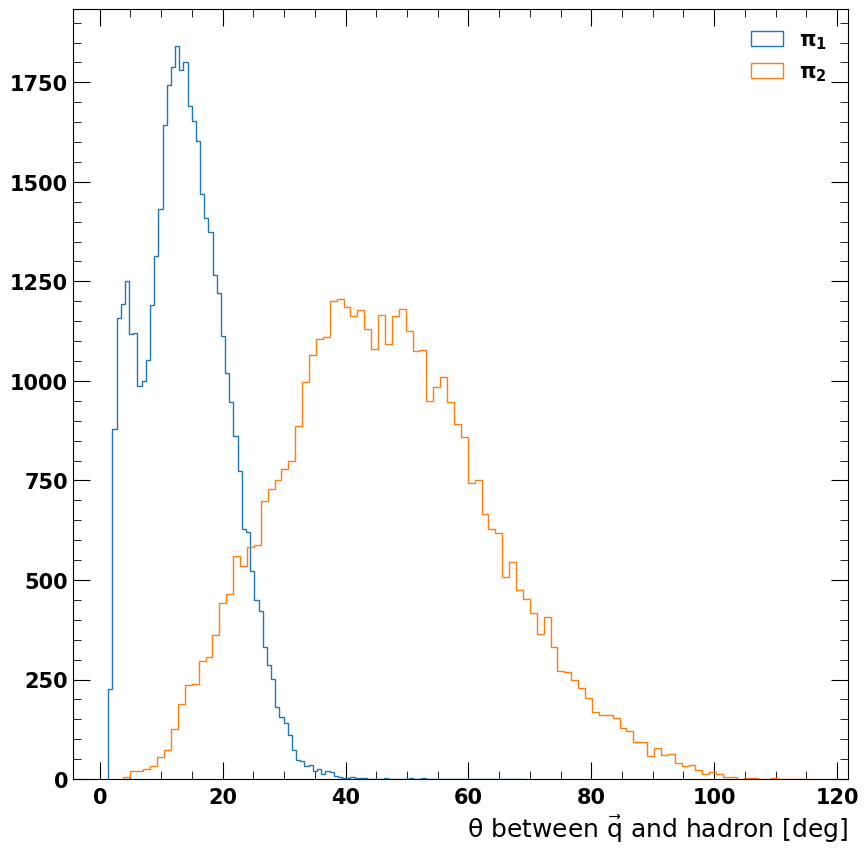

<theta1>= 13.955511724015595
<theta2>= 46.67817397574598


In [92]:
print(df['D_C'].columns)
plt.hist(df["D_C"].query("(h1_cm_pt**2)>0.005 and (h2_cm_pt**2)>0.005").eval("arcsin(h1_cm_pt/h1_p)*180/3.14159"), bins=100, histtype='step', label="$\\pi_1$")
plt.hist(df["D_C"].query("(h1_cm_pt**2)>0.005 and (h2_cm_pt**2)>0.005").eval("arcsin(h2_cm_pt/h2_p)*180/3.14159*(2*(h2_rap+ycm>0)-1)+180*(h2_rap+ycm<0)"), bins=100, histtype='step', label="$\\pi_2$")
plt.xlabel("$\\theta$ between $\\vec q$ and hadron [deg]")
plt.legend()
plt.show()

print("<theta1>=",np.mean(df["D_C"].query("(h1_cm_pt**2)>0.005 and (h2_cm_pt**2)>0.005").eval("arcsin(h1_cm_pt/h1_p)*180/3.14159")))
        

print("<theta2>=",np.mean(df["D_C"].query("(h1_cm_pt**2)>0.005 and (h2_cm_pt**2)>0.005")\
         .eval("arcsin(h2_cm_pt/h2_p)*180/3.14159*(2*(h2_rap+ycm>0)-1)+180*(h2_rap+ycm<0)")))

In [ ]:
print(df['D_C'].columns)
plt.hist(df["D_C"].query("(h1_cm_pt**2)>0.005 and (h2_cm_pt**2)>0.005")\
         .eval("(arcsin(h1_cm_pt/h1_p)*180/3.14159*(2*(h1_rap+ycm>0)-1)+180*(h1_rap+ycm<0))-(arcsin(h2_cm_pt/h2_p)*180/3.14159*(2*(h2_rap+ycm>0)-1)+180*(h2_rap+ycm<0))"), 
         bins=100, histtype='step')

plt.xlabel("$\\theta_1-\\theta_2$ [deg]")
plt.legend()
plt.show()
#plt.hist(df["D_C"].eval("h2_rap"))
#plt.show()

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')


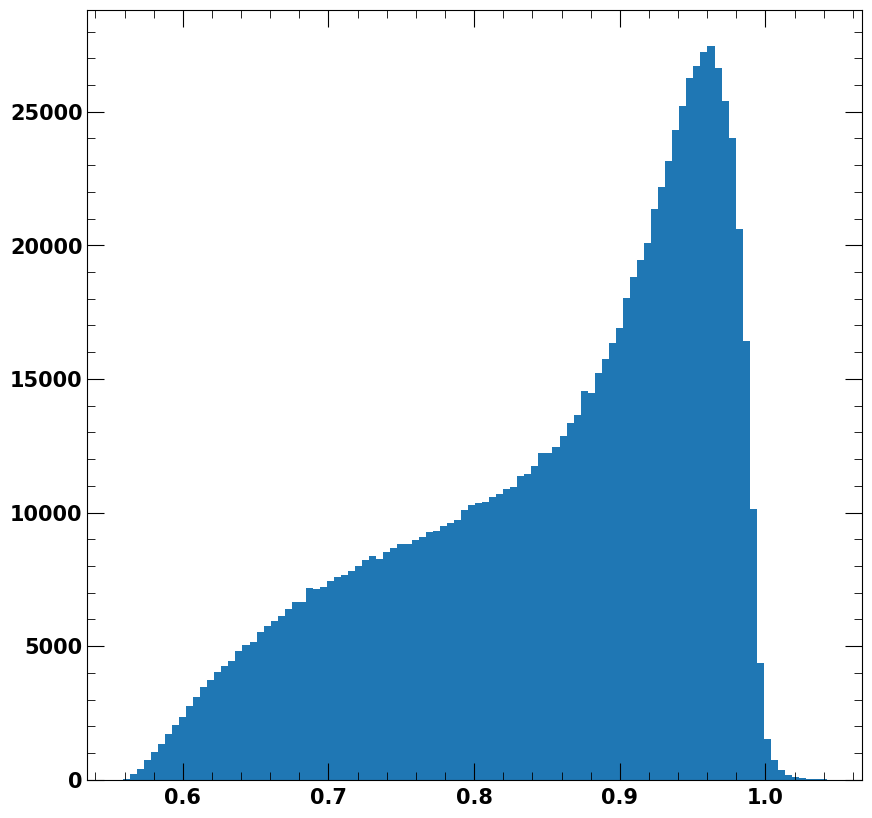

In [53]:
print(df['GiBUU_D'].columns)
plt.hist(df['GiBUU_D'].query("h1_pid*h2_pid==-211**2")., bins=100)
plt.show()

In [79]:
df["GiBUU_D"].columns

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')

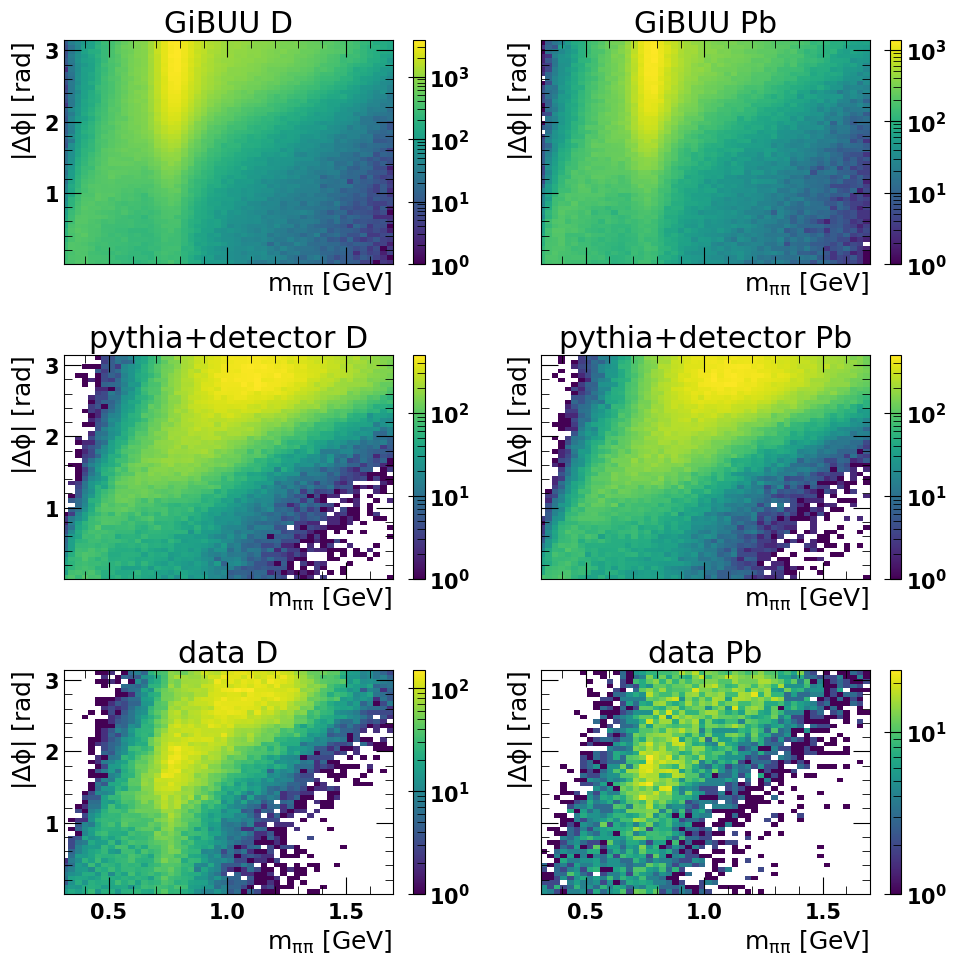

In [81]:
fig, axs= plt.subplots(3,2, sharex='all', sharey='all')

for i,(label,key) in enumerate(zip(("GiBUU D", "GiBUU Pb", "pythia+detector D", "pythia+detector Pb",  "data D", "data Pb"),
                                   ('GiBUU_D', 'GiBUU_Pb',"MC_D","MC_Pb", "D_Pb", "Pb"))):
    thedf= df[key] if "MC_" not in key else df_mc[key.replace("MC_","")]
    if "h1_cm_pt" in thedf.columns:
        thedf = thedf.query("h1_cm_pt>sqrt(0.005) and h2_cm_pt>sqrt(0.005)")
    #else:
    #    thedf = thedf.query("h1_pt>sqrt(0.005) and h2_pt>sqrt(0.005)")
    plt.sca(axs[i//2][i%2])
    plt.hist2d(thedf.eval("pair_mass"),thedf.eval("dphi"),bins=50,norm=mpl.colors.LogNorm())
    plt.ylabel("$|\Delta\phi|$ [rad]")
    plt.xlabel("$m_{\pi\pi}$ [GeV]")
    plt.title(label)
    plt.colorbar()
plt.tight_layout()
plt.savefig("images/mass_vs_dphi.png")
plt.show()